In [1]:
import sys
import time
import os

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from ipywidgets.widgets import Button, Layout, VBox, HBox, HTML
from IPython.display import display

sys.path.insert(0, 'code')
from makeData import VKDataGetter

%matplotlib inline
sns.set_style('whitegrid')

# Получения данных о пользователях при помощи API "Вконтакте"

In [2]:
vk_group_id = "31272583"

with open('token', 'r') as file:
    vk_token = file.read()
vk = VKDataGetter(vk_token)
    
if os.path.isfile(f"data/users_{vk_group_id}.csv"):
    users_df = pd.read_csv(f"data/users_{vk_group_id}.csv")
else:
    users_df = vk.getUserIDs(vk_group_id, count=2500)
    
    #filter all blocked users and users with closed profile
    users_df = users_df[~(users_df['deactivated'] | users_df['is_closed'])]
    users_df = users_df[['id', 'first_name', 'last_name', 'photo_max_orig']]
    
    users_df.to_csv(f"data/users_{vk_group_id}.csv", index=False)
print(f"Number of subscribers after filtering = {len(users_df.index)}")
users_df.head()

Number of subscribers after filtering = 2109


id first_name   last_name  \
0   40439      Мария      Рыкова   
1   45024       Саша      Иванов   
2   66732   Антонина     Волкова   
3  136097    Татьяна      Орлова   
4  360143   Вероника  Сухорукова   

                                      photo_max_orig  
0  https://sun1-25.userapi.com/impg/KyIkBc5V6bRhj...  
1  https://sun1-15.userapi.com/impf/c626219/v6262...  
2  https://sun1-92.userapi.com/impf/c830400/v8304...  
3  https://sun1-14.userapi.com/impf/c841626/v8416...  
4  https://sun1-47.userapi.com/impg/3Onhcn2EDFDP3...

In [3]:
if os.path.isfile(f"data/users_subs_{vk_group_id}.csv"):
    users_subs = pd.read_csv(f"data/users_subs_{vk_group_id}.csv")
else:
    users_groups = []
    users_ids = np.array(users_df['id'])
    
    for i, user_id in enumerate(users_ids):
        try:
            user_groups = vk.getUsersGroups(user_id)
            users_groups += [(user_id, group_id) for group_id in user_groups]
            time.sleep(0.4)
        except:
            print(f"Failed to get subscriptions for user {user}")
        if i % 250 == 0:
            print(f"{i} users are passed")
        
    users_subs = pd.DataFrame(data=users_groups, columns=['user_id', 'group_id'])
    users_subs.to_csv(f"data/users_subs_{vk_group_id}.csv", index=False)

print(users_subs.shape)
users_subs.head(10)

(431937, 2)


user_id   group_id
0    40439   74904052
1    40439  132754082
2    40439  173695189
3    40439   68072717
4    40439   33005291
5    40439  199664174
6    40439  200352366
7    40439   92307020
8    40439  195972147
9    40439  133194853

# Обработка и анализ данных

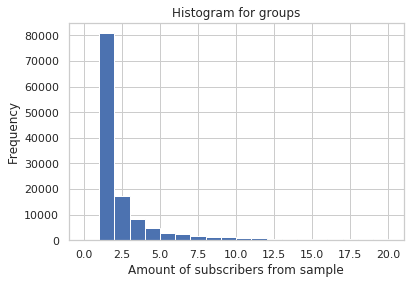

In [4]:
subscriptions_per_group = users_subs.groupby('group_id')['user_id'].count()

fig, ax = plt.subplots()
ax.set_title('Histogram for groups')
ax.set_xlabel('Amount of subscribers from sample')
ax.set_ylabel('Frequency')
hist = subscriptions_per_group.hist(bins=20, range=(0, 20), ax=ax)

In [5]:
users_subs['subscribed'] = 1
pivot_table = users_subs.pivot_table(index='user_id', columns='group_id', values='subscribed')
pivot_table = pivot_table.fillna(0).astype('bool')
pivot_table.head()

group_id  1          11         12         16         21         26         \
user_id                                                                      
40439         False      False      False      False      False      False   
45024         False      False      False      False      False      False   
66732         False      False      False      False      False      False   
136097        False       True      False      False      False      False   
360143        False      False      False      False      False      False   

group_id  27         28         33         41         ...  201291974  \
user_id                                               ...              
40439         False      False      False      False  ...      False   
45024         False      False      False      False  ...      False   
66732         False      False      False      False  ...      False   
136097        False      False       True      False  ...      False   
360143        False      False      False      False  ...      False   

group_id  201291989  201291992  201292027  201292038  201292070  201292121  \
user_id                                                                      
40439         False      False      False      False      False      False   
45024         False      False      False      False      False      False   
66732         False      False      False      False      False      False   
136097        False      False      False      False      False      False   
360143        False      False      False      False      False      False   

group_id  201292176  201292296  201300266  
user_id                                    
40439         False      False      False  
45024         False      False      False  
66732         False      False      False  
136097        False      False      False  
360143        False      False      False  

[5 rows x 128813 columns]

In [6]:
subscriptions_per_group_df = pd.DataFrame(subscriptions_per_group)
filtered_df = subscriptions_per_group_df[subscriptions_per_group_df['user_id'] > 1]
filtered_groups = filtered_df.index.to_list()

filtered_users_subs = users_subs[users_subs['group_id'].isin(filtered_groups)].copy()

In [7]:
filtered_pivot_table = filtered_users_subs.pivot_table(index='user_id', columns='group_id', values='subscribed')
filtered_pivot_table = filtered_pivot_table.fillna(0).astype('bool')
filtered_pivot_table.head()

group_id  1          11         21         28         33         41         \
user_id                                                                      
40439         False      False      False      False      False      False   
45024         False      False      False      False      False      False   
66732         False      False      False      False      False      False   
136097        False       True      False      False       True      False   
360143        False      False      False      False      False      False   

group_id  47         88         91         94         ...  200405573  \
user_id                                               ...              
40439         False      False      False      False  ...      False   
45024         False      False      False      False  ...      False   
66732         False      False      False      False  ...      False   
136097        False      False      False      False  ...      False   
360143        False      False      False      False  ...      False   

group_id  200419128  200463099  200468089  200645735  200757368  200809000  \
user_id                                                                      
40439         False      False      False      False      False      False   
45024         False      False      False      False      False      False   
66732         False      False      False      False      False      False   
136097        False      False      False      False      False      False   
360143        False      False      False      False      False      False   

group_id  200869881  200942281  201194525  
user_id                                    
40439         False      False      False  
45024         False      False      False  
66732         False      False      False  
136097        False      False      False  
360143        False      False      False  

[5 rows x 47963 columns]

In [8]:
suggest_len = 25
nn_model = NearestNeighbors(n_neighbors=suggest_len, metric="jaccard")
nn_model.fit(filtered_pivot_table.values)
d, n = nn_model.kneighbors(filtered_pivot_table.loc[87069269].to_numpy().reshape(1, -1))

In [9]:
for uid, dist in zip(n[0],d[0]):
    print(f"user id: {uid} \t distance: {round(dist,2)}")

user id: 1380 	 distance: 0.0
user id: 1719 	 distance: 0.67
user id: 745 	 distance: 0.71
user id: 1286 	 distance: 0.71
user id: 1717 	 distance: 0.71
user id: 1306 	 distance: 0.71
user id: 1600 	 distance: 0.71
user id: 22 	 distance: 0.78
user id: 1096 	 distance: 0.8
user id: 1266 	 distance: 0.8
user id: 376 	 distance: 0.8
user id: 1431 	 distance: 0.8
user id: 1563 	 distance: 0.8
user id: 1504 	 distance: 0.8
user id: 920 	 distance: 0.82
user id: 1854 	 distance: 0.82
user id: 1460 	 distance: 0.82
user id: 1672 	 distance: 0.82
user id: 1812 	 distance: 0.82
user id: 535 	 distance: 0.82
user id: 444 	 distance: 0.83
user id: 1024 	 distance: 0.83
user id: 1913 	 distance: 0.83
user id: 1805 	 distance: 0.83
user id: 1407 	 distance: 0.83


# Прототип пользовательского интерфейса

In [ ]:
current_index = 1

def clickNext(b):
    global current_index, suggest_len
    if current_index + 1 < suggest_len:
        current_index += 1
        renderPage()

def clickPrev(b):
    global current_index
    if current_index > 1:
        current_index -= 1
        renderPage()

def renderPage():
    global current_index, image, user_name, go_btn, match_percent
    image.value = '<img style="' + image_styles + '" src="' + users_df.iloc[n[0][current_index]]['photo_max_orig'] + '">'
    user_name.value = '<b style="' + user_name_styles + '">' + users_df.iloc[n[0][current_index]]['first_name'] + ' ' + users_df.iloc[n[0][current_index]]['last_name'] + '</b>'
    go_btn.value = '<a target="_blank" style="' + go_btn_styles + '" href="https://vk.com/id' + str(users_df.iloc[n[0][current_index]]['id']) + '"><span>Открыть страницу</span></a>'
    percent = int((1 - round(d[0,current_index], 2)) * 100)
    match_styles = 'font-size: 32px; color:' + ('green' if percent > 25 else 'red') +'; display:flex; justify-content: center; margin: 10px;'
    match_percent.value = '<b style="' + match_styles + '">' + str(percent) + '%</b>'
    
next_btn = Button(
    description = "Дальше",
    layout = Layout(
        width = '45%',
        height = '40px',
    ),
    button_style = 'success',
    icon = 'arrow-right',
)

prev_btn = Button(
    description = "Назад",
    layout = Layout(
        width = '45%',
        height = '40px',
    ),
    button_style = 'warning',
    icon = 'arrow-left'
)

next_btn.on_click(clickNext)
prev_btn.on_click(clickPrev)

percent = int((1 - round(d[0,current_index], 2)) * 100)
match_styles = 'font-size: 32px; color:' + ('green' if percent > 25 else 'red') +'; display:flex; justify-content: center; margin: 10px;'
match_percent = HTML(
    value = '<b style="' + match_styles + '">' + str(percent) + '%</b>'
)

image_styles = 'width:300px; height:400px'
image = HTML(
    value = '<img style="' + image_styles + '" src="' + users_df.iloc[n[0][current_index]]['photo_max_orig'] + '">'
)

user_name_styles = 'font-size: 28px; display:flex; justify-content: center;'
user_name = HTML(
    value = '<b style="' + user_name_styles + '">' + users_df.iloc[n[0][current_index]]['first_name'] + ' ' + users_df.iloc[n[0][current_index]]['last_name'] + '</b>'
)

go_btn_styles = 'margin: 15px; background-color: #0b97d4; font-size:24px; padding: 10px; display:flex; justify-content: center; color: white; border-radius: 10px; text-decoration: none;'
go_btn = HTML(
    value = '<a target="_blank" style="' + go_btn_styles + '" href="https://vk.com/id' + str(users_df.iloc[n[0][current_index]]['id']) + '"><span>Открыть страницу</span></a>'
)

info = VBox(
    children = (match_percent, image, user_name, go_btn)
)


btn_box = HBox(
    children = (prev_btn, next_btn),
    layout = Layout(
        width = '100%',
        height = 'auto',
        display = 'flex',
        justify_content = 'center'
    )
)

app = VBox(
    children = (info, btn_box),
    layout = Layout(
        border = 'solid 2px black',
        width = '480px',
        height = 'auto',
        display = 'flex',
        align_items = 'center'
    )
)

display(app)